# Set Up

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# change to your working directory
#%cd "/content/drive/MyDrive/shared folder/Master_Thesis"
%cd "/content/drive/MyDrive/shared_folder/Master_Thesis" 

/content/drive/.shortcut-targets-by-id/1lHcON5EHJDerZlJ2mPUGsY4w6iFLBKs5/shared_folder/Master_Thesis


In [ ]:
!pip install adapt

In [ ]:
import os, random, shutil, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from PIL import Image

from sklearn.preprocessing import OneHotEncoder
from sklearn.manifold import TSNE

import tensorflow as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adagrad
from tensorflow.keras.layers import Dense, Input, Dropout, Conv2D, MaxPooling2D, Flatten, Reshape, GaussianNoise 
from tensorflow.keras.layers import BatchNormalization,  GlobalMaxPooling2D, GlobalAveragePooling2D,  Add
from tensorflow.keras.applications import VGG16, InceptionV3, ResNet50, ResNet50V2, MobileNetV3Large
from tensorflow.keras.constraints import MinMaxNorm, MaxNorm
from tensorflow.keras.applications.resnet50 import preprocess_input, ResNet50
from tensorflow.keras.models import Model, load_model
from keras.preprocessing.image import load_img, img_to_array, array_to_img
from tensorflow.keras.optimizers.schedules import LearningRateSchedule

from adapt.parameter_based import FineTuning
from adapt.feature_based import MDD
from adapt.utils import UpdateLambda

In [ ]:
print("GPU Available: ", tf.test.is_gpu_available())
print(tf.__version__)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU Available:  True
2.8.0


In [ ]:
# Original Dataset
Source_dir_train1 = "./Images/DANN/Source/LC25000_mix_data_512_3200_train1.pkl"
Source_dir_train2 = "./Images/DANN/Source/LC25000_mix_data_512_3200_train2.pkl"
Source_dir_train3 = "./Images/DANN/Source/LC25000_mix_data_512_3200_train3.pkl"


Target_dir_train1 = os.path.abspath("./Images/DANN/Target/TCGA_mix_data_512_3200_train1.pkl")
Target_dir_train2 = os.path.abspath("./Images/DANN/Target/TCGA_mix_data_512_3200_train2.pkl")
Target_dir_test1 = os.path.abspath("./Images/DANN/Target/TCGA_mix_data_512_3200_test1.pkl")
Target_dir_test2 = os.path.abspath("./Images/DANN/Target/TCGA_mix_data_512_3200_test2.pkl")

# Cyclegan Dataset

Target_cyclegan_dir_train1 = os.path.abspath("./Images/DANN/Target_cyclegan/TCGA_cyclegan_mix_data_512_3200_train1.pkl")
Target_cyclegan_dir_train2 = os.path.abspath("./Images/DANN/Target_cyclegan/TCGA_cyclegan_mix_data_512_3200_train2.pkl")
Target_cyclegan_dir_test1 = os.path.abspath("./Images/DANN/Target_cyclegan/TCGA_cyclegan_mix_data_512_3200_test1.pkl")
Target_cyclegan_dir_test2 = os.path.abspath("./Images/DANN/Target_cyclegan/TCGA_cyclegan_mix_data_512_3200_test2.pkl")

In [ ]:
CHANNELS = 3
IMAGE_HEIGHT = 512
IMAGE_WIDTH = 512

# Loading Dataset

## LC25000 Dataset

In [ ]:
# LC25000 Dataset
with open(os.path.abspath(Source_dir_train1), "rb") as f:
    LC25000_train1 = pickle.load(f)
with open(os.path.abspath(Source_dir_train2), "rb") as f:
    LC25000_train2 = pickle.load(f)
with open(os.path.abspath(Source_dir_train3), "rb") as f:
    LC25000_train3 = pickle.load(f)

In [ ]:
# LC25000_train_data = LC25000_train1['train'] + LC25000_train2['train'] + LC25000_train3['train'] 
# LC25000_train_labels = np.concatenate((LC25000_train1['train_label'],LC25000_train2['train_label'],LC25000_train3['train_label']))
# LC25000_train_data = LC25000_train1['train'][0:400] + LC25000_train2['train'][0:400] + LC25000_train3['train'][0:400] 
# LC25000_train_labels = np.concatenate((LC25000_train1['train_label'][0:400],LC25000_train2['train_label'][0:400],LC25000_train3['train_label'][0:400]))
LC25000_train_data = LC25000_train1['train'][0:533] + LC25000_train2['train'][0:534] + LC25000_train3['train'][0:533] 
LC25000_train_labels = np.concatenate((LC25000_train1['train_label'][0:533],LC25000_train2['train_label'][0:534],LC25000_train3['train_label'][0:533]))

In [ ]:
LC25000_train_lab = tf.one_hot(LC25000_train_labels, depth=3)

In [ ]:
LC25000_train_data = np.array(LC25000_train_data, dtype=np.float32)

In [ ]:
print("The shape of LC25000_train_data: ", np.shape(LC25000_train_data))
print("The shape of LC25000_train_labels: ", np.shape(LC25000_train_labels))

The shape of LC25000_train_data:  (1600, 512, 512, 3)
The shape of LC25000_train_labels:  (1600,)


In [ ]:
import gc
gc.collect()

272

## TCGA Cyclegan Dataset

In [ ]:
# TCGA Dataset
with open(os.path.abspath(Target_dir_train1), "rb") as f:
    TCGA_train1 = pickle.load(f)
with open(os.path.abspath(Target_dir_train2), "rb") as f:
    TCGA_train2 = pickle.load(f)
# with open(os.path.abspath(Target_cyclegan_dir_train1), "rb") as f:
#     TCGA_cyclegan_train1 = pickle.load(f)
# with open(os.path.abspath(Target_cyclegan_dir_train2), "rb") as f:
#     TCGA_cyclegan_train2 = pickle.load(f)
# with open(os.path.abspath(Target_cyclegan_dir_test1), "rb") as f:
#     TCGA_cyclegan_test1 = pickle.load(f)
# with open(os.path.abspath(Target_cyclegan_dir_test2), "rb") as f:
#     TCGA_cyclegan_test2 = pickle.load(f)

In [ ]:
TCGA_cyclegan_train_data = TCGA_train1['train'][0:800] + TCGA_train2['train'][0:800]
TCGA_cyclegan_train_labels = np.concatenate((TCGA_train1['train_label'][0:800],TCGA_train2['train_label'][0:800]))
# TCGA_cyclegan_train_data = TCGA_cyclegan_train1['train'] + TCGA_cyclegan_train2['train']
# TCGA_cyclegan_train_labels = np.concatenate((TCGA_cyclegan_train1['train_label'],TCGA_cyclegan_train2['train_label']))
# TCGA_cyclegan_test_data = TCGA_cyclegan_test1['test'] + TCGA_cyclegan_test2['test']
# TCGA_cyclegan_test_labels = np.concatenate((TCGA_cyclegan_test1['test_label'],TCGA_cyclegan_test2['test_label']))

In [ ]:
TCGA_cyclegan_train_lab = tf.one_hot(TCGA_cyclegan_train_labels, depth=3)
# TCGA_cyclegan_test_lab = tf.one_hot(TCGA_cyclegan_test_labels, depth=3)

In [ ]:
TCGA_cyclegan_train_data = np.array(TCGA_cyclegan_train_data, dtype=np.float32)
# TCGA_cyclegan_test_data = np.array(TCGA_cyclegan_test_data, dtype=np.float32)

In [ ]:
print("The shape of TCGA_cyclegan_train_data: ", TCGA_cyclegan_train_data.shape)
print("The shape of TCGA_cyclegan_train_labels: ", TCGA_cyclegan_train_labels.shape)
# print("The shape of TCGA_cyclegan_test_data: ", TCGA_cyclegan_test_data.shape)
# print("The shape of TCGA_cyclegan_test_labels: " , TCGA_cyclegan_test_labels.shape)

The shape of TCGA_cyclegan_train_data:  (1600, 512, 512, 3)
The shape of TCGA_cyclegan_train_labels:  (1600,)


In [ ]:
import gc
gc.collect()

253

## Datasets Visualization

<function matplotlib.pyplot.show>

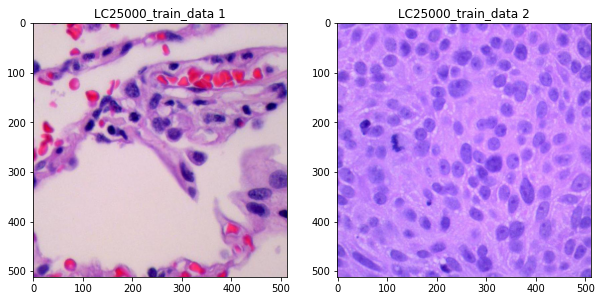

In [ ]:
# random show source images
fig = plt.subplots(1,2,figsize=(10,10))
#plt.suptitle("Source Domain = LC25000", fontsize=18)
ax1=plt.subplot(1,2,1)
sample1 = random.choice(LC25000_train_data)
img1 = array_to_img(sample1)
plt.show
plt.title("LC25000_train_data 1")
plt.imshow(img1)
ax1=plt.subplot(1,2,2)
sample2 = random.choice(LC25000_train_data)
img2 = array_to_img(sample2)
plt.title("LC25000_train_data 2")
plt.imshow(img2)
plt.show

<function matplotlib.pyplot.show>

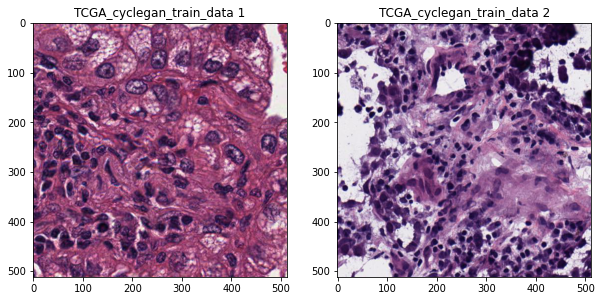

In [ ]:
# random show images
plt.subplots(1,2,figsize=(10,10))
ax1=plt.subplot(1,2,1)
sample1 = random.choice(TCGA_cyclegan_train_data)
img1 = array_to_img(sample1)
plt.title("TCGA_cyclegan_train_data 1")
plt.imshow(img1)
ax1=plt.subplot(1,2,2)
sample2 = random.choice(TCGA_cyclegan_train_data)
img2 = array_to_img(sample2)
plt.title("TCGA_cyclegan_train_data 2")
plt.imshow(img2)
plt.show

# Domain Adaptation

## Build Model

### Feature Extractor - ResNet50V2

In [ ]:
resnet50 = ResNet50(include_top=False, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS), pooling="avg")

first_layer = resnet50.get_layer('conv5_block2_out')
inputs = Input(first_layer.output_shape[1:])

for layer in resnet50.layers[resnet50.layers.index(first_layer)+1:]:
    if layer.name == "conv5_block3_1_conv":
        x = layer(inputs)
    elif layer.name == "conv5_block3_add":  # change name
        x = layer([inputs, x])
    else:
        if layer.name == "conv5_block3_preact_bn":
            pass
        else:
            x = layer(x)

first_blocks = Model(resnet50.input, first_layer.output)
last_block = Model(inputs, x)

In [ ]:
def load_resnet50(path="./Model/DANN_Model/resnet50_last_block_512.hdf5"):
    model = load_model(path)
    for i in range(len(model.layers)):
        if model.layers[i].__class__.__name__ == "BatchNormalization":
            model.layers[i].trainable = False
    return model

last_block.summary()
last_block.save("./Model/DANN_Model/resnet50_last_block_512.hdf5")

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 16, 16, 204  0           []                               
                                8)]                                                               
                                                                                                  
 conv5_block3_1_conv (Conv2D)   (None, 16, 16, 512)  1049088     ['input_2[0][0]']                
                                                                                                  
 conv5_block3_1_bn (BatchNormal  (None, 16, 16, 512)  2048       ['conv5_block3_1_conv[1][0]']    
 ization)                                                                                         
                                                                                            

### Extract the features 

In [ ]:
LC25000_train_data_ex = first_blocks.predict(preprocess_input(np.stack(LC25000_train_data)))

In [ ]:
gc.collect()

1150

In [ ]:
TCGA_cyclegan_train_data_ex = first_blocks.predict(preprocess_input(np.stack(TCGA_cyclegan_train_data)))

In [ ]:
gc.collect()

693

In [ ]:
print("LC25000_train_data (source) shape: %s"%str(LC25000_train_data.shape))
print("TCGA_cyclegan_train_data (target) shape: %s"%str(TCGA_cyclegan_train_data.shape))

LC25000_train_data (source) shape: (1600, 512, 512, 3)
TCGA_cyclegan_train_data (target) shape: (1600, 512, 512, 3)


### Label Predictor

In [ ]:
def get_task(dropout=0.5, max_norm=0.5):
    model = Sequential()
    model.add(Dense(1024, activation="relu",
                   kernel_constraint=MaxNorm(max_norm),
                   bias_constraint=MaxNorm(max_norm)))
    model.add(Dropout(dropout))
    model.add(Dense(1024, activation="relu",
                   kernel_constraint=MaxNorm(max_norm),
                   bias_constraint=MaxNorm(max_norm)))
    model.add(Dropout(dropout))
    model.add(Dense(3, activation="softmax",
                   kernel_constraint=MaxNorm(max_norm),
                   bias_constraint=MaxNorm(max_norm)))
    return model

In [ ]:
class MyDecay(LearningRateSchedule):

    def __init__(self, max_steps=1000, mu_0=0.01, alpha=10, beta=0.75):
        self.mu_0 = mu_0
        self.alpha = alpha
        self.beta = beta
        self.max_steps = float(max_steps)

    def __call__(self, step):
        p = step / self.max_steps
        return self.mu_0 / (1+self.alpha * p)**self.beta

# Fit without adaptation

### Run 1

In [ ]:
lr = 1e-6
momentum = 0.9
alpha = 0.0002

optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),  momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha), momentum=momentum)

In [ ]:
finetunig = FineTuning(encoder=load_resnet50(),
                         task=get_task(),
                         optimizer=optimizer_task,
                         optimizer_enc=optimizer_enc,
                         loss="categorical_crossentropy",
                         metrics=["acc"],
                         copy=False,
                         pretrain=True,
                         pretrain__epochs=5)

In [ ]:
finetunig.fit(LC25000_train_data_ex, LC25000_train_lab, epochs=100, batch_size=8, validation_data=(TCGA_cyclegan_train_data_ex, TCGA_cyclegan_train_lab))

Epoch 1/5
200/200 [==============================] - 7s 30ms/step - loss: 0.9438 - acc: 0.6325 - val_loss: 1.0780 - val_acc: 0.1256
Epoch 2/5
200/200 [==============================] - 4s 21ms/step - loss: 0.6048 - acc: 0.8281 - val_loss: 1.0453 - val_acc: 0.2894
Epoch 3/5
200/200 [==============================] - 4s 21ms/step - loss: 0.4057 - acc: 0.8831 - val_loss: 0.8080 - val_acc: 0.6325
Epoch 4/5
200/200 [==============================] - 4s 21ms/step - loss: 0.2921 - acc: 0.9175 - val_loss: 0.7342 - val_acc: 0.6656
Epoch 5/5
200/200 [==============================] - 4s 21ms/step - loss: 0.2292 - acc: 0.9262 - val_loss: 0.6855 - val_acc: 0.6944
Epoch 1/100
200/200 [==============================] - 9s 37ms/step - loss: 0.1965 - acc: 0.9369 - val_loss: 0.5926 - val_acc: 0.7381
Epoch 2/100
200/200 [==============================] - 5s 27ms/step - loss: 0.1645 - acc: 0.9463 - val_loss: 0.7674 - val_acc: 0.6388
Epoch 3/100
200/200 [==============================] - 5s 27ms/step - lo

### Run 2

In [ ]:
lr = 1e-6
momentum = 0.9
alpha = 0.0002

optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),  momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha), momentum=momentum)

In [ ]:
finetunig = FineTuning(encoder=load_resnet50(),
                         task=get_task(),
                         optimizer=optimizer_task,
                         optimizer_enc=optimizer_enc,
                         loss="categorical_crossentropy",
                         metrics=["acc"],
                         copy=False,
                         pretrain=True,
                         pretrain__epochs=3)

In [ ]:
finetunig.fit(LC25000_train_data_ex, LC25000_train_lab, epochs=80, batch_size=8, validation_data=(TCGA_cyclegan_train_data_ex, TCGA_cyclegan_train_lab))

Epoch 1/3
200/200 [==============================] - 7s 29ms/step - loss: 0.9377 - acc: 0.6469 - val_loss: 1.0799 - val_acc: 0.1562
Epoch 2/3
200/200 [==============================] - 4s 22ms/step - loss: 0.5897 - acc: 0.8394 - val_loss: 0.9961 - val_acc: 0.3494
Epoch 3/3
200/200 [==============================] - 4s 22ms/step - loss: 0.3879 - acc: 0.8856 - val_loss: 0.7812 - val_acc: 0.6250
Epoch 1/80
200/200 [==============================] - 10s 35ms/step - loss: 0.2878 - acc: 0.9075 - val_loss: 0.7382 - val_acc: 0.6444
Epoch 2/80
200/200 [==============================] - 5s 27ms/step - loss: 0.2163 - acc: 0.9356 - val_loss: 0.6037 - val_acc: 0.7337
Epoch 3/80
200/200 [==============================] - 5s 27ms/step - loss: 0.1771 - acc: 0.9419 - val_loss: 0.6474 - val_acc: 0.6994
Epoch 4/80
200/200 [==============================] - 5s 27ms/step - loss: 0.1575 - acc: 0.9431 - val_loss: 0.6235 - val_acc: 0.7150
Epoch 5/80
200/200 [==============================] - 5s 27ms/step - lo

### Run 3

In [ ]:
lr = 1e-6
momentum = 0.9
alpha = 0.0002

optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),  momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha), momentum=momentum)

In [ ]:
finetunig = FineTuning(encoder=load_resnet50(),
                         task=get_task(),
                         optimizer=optimizer_task,
                         optimizer_enc=optimizer_enc,
                         loss="categorical_crossentropy",
                         metrics=["acc"],
                         copy=False,
                         pretrain=True,
                         pretrain__epochs=3)

In [ ]:
finetunig.fit(LC25000_train_data_ex, LC25000_train_lab, epochs=80, batch_size=8, validation_data=(TCGA_cyclegan_train_data_ex, TCGA_cyclegan_train_lab))

Epoch 1/3
200/200 [==============================] - 7s 29ms/step - loss: 0.9550 - acc: 0.6331 - val_loss: 1.1346 - val_acc: 0.0106
Epoch 2/3
200/200 [==============================] - 5s 24ms/step - loss: 0.6239 - acc: 0.8081 - val_loss: 1.0371 - val_acc: 0.2988
Epoch 3/3
200/200 [==============================] - 4s 22ms/step - loss: 0.4157 - acc: 0.8781 - val_loss: 0.8206 - val_acc: 0.6294
Epoch 1/80
200/200 [==============================] - 10s 35ms/step - loss: 0.2928 - acc: 0.9175 - val_loss: 0.7793 - val_acc: 0.6263
Epoch 2/80
200/200 [==============================] - 5s 27ms/step - loss: 0.2175 - acc: 0.9300 - val_loss: 0.6887 - val_acc: 0.6762
Epoch 3/80
200/200 [==============================] - 5s 27ms/step - loss: 0.1846 - acc: 0.9356 - val_loss: 0.6627 - val_acc: 0.6975
Epoch 4/80
200/200 [==============================] - 5s 27ms/step - loss: 0.1682 - acc: 0.9350 - val_loss: 0.6453 - val_acc: 0.7088
Epoch 5/80
200/200 [==============================] - 5s 27ms/step - lo

### Run 4

In [ ]:
lr = 1e-6
momentum = 0.9
alpha = 0.0002

optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),  momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha), momentum=momentum)

In [ ]:
finetunig = FineTuning(encoder=load_resnet50(),
                         task=get_task(),
                         optimizer=optimizer_task,
                         optimizer_enc=optimizer_enc,
                         loss="categorical_crossentropy",
                         metrics=["acc"],
                         copy=False,
                         pretrain=True,
                         pretrain__epochs=3)

In [ ]:
finetunig.fit(LC25000_train_data_ex, LC25000_train_lab, epochs=80, batch_size=8, validation_data=(TCGA_cyclegan_train_data_ex, TCGA_cyclegan_train_lab))

Epoch 1/3
200/200 [==============================] - 7s 29ms/step - loss: 0.9652 - acc: 0.6231 - val_loss: 1.0576 - val_acc: 0.1956
Epoch 2/3
200/200 [==============================] - 5s 21ms/step - loss: 0.6343 - acc: 0.8356 - val_loss: 0.9744 - val_acc: 0.4162
Epoch 3/3
200/200 [==============================] - 4s 21ms/step - loss: 0.4146 - acc: 0.8894 - val_loss: 0.8419 - val_acc: 0.5813
Epoch 1/80
200/200 [==============================] - 10s 37ms/step - loss: 0.2957 - acc: 0.9087 - val_loss: 0.7535 - val_acc: 0.6325
Epoch 2/80
200/200 [==============================] - 6s 28ms/step - loss: 0.2185 - acc: 0.9331 - val_loss: 0.7820 - val_acc: 0.6137
Epoch 3/80
200/200 [==============================] - 6s 28ms/step - loss: 0.1780 - acc: 0.9450 - val_loss: 0.6444 - val_acc: 0.7013
Epoch 4/80
200/200 [==============================] - 6s 28ms/step - loss: 0.1619 - acc: 0.9463 - val_loss: 0.7109 - val_acc: 0.6675
Epoch 5/80
200/200 [==============================] - 6s 28ms/step - lo

### Run 5

In [ ]:
lr = 1e-6
momentum = 0.9
alpha = 0.0002

optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),  momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha), momentum=momentum)

In [ ]:
finetunig = FineTuning(encoder=load_resnet50(),
                         task=get_task(),
                         optimizer=optimizer_task,
                         optimizer_enc=optimizer_enc,
                         loss="categorical_crossentropy",
                         metrics=["acc"],
                         copy=False,
                         pretrain=True,
                         pretrain__epochs=3)

In [ ]:
finetunig.fit(LC25000_train_data_ex, LC25000_train_lab, epochs=80, batch_size=8, validation_data=(TCGA_cyclegan_train_data_ex, TCGA_cyclegan_train_lab))

Epoch 1/3
200/200 [==============================] - 7s 29ms/step - loss: 0.9574 - acc: 0.5900 - val_loss: 1.1410 - val_acc: 0.0075
Epoch 2/3
200/200 [==============================] - 5s 26ms/step - loss: 0.6391 - acc: 0.7944 - val_loss: 0.9836 - val_acc: 0.4106
Epoch 3/3
200/200 [==============================] - 4s 22ms/step - loss: 0.4215 - acc: 0.8712 - val_loss: 0.8453 - val_acc: 0.5938
Epoch 1/80
200/200 [==============================] - 10s 35ms/step - loss: 0.3020 - acc: 0.9106 - val_loss: 0.7364 - val_acc: 0.6525
Epoch 2/80
200/200 [==============================] - 5s 27ms/step - loss: 0.2226 - acc: 0.9250 - val_loss: 0.6312 - val_acc: 0.7044
Epoch 3/80
200/200 [==============================] - 6s 29ms/step - loss: 0.1816 - acc: 0.9400 - val_loss: 0.6772 - val_acc: 0.6731
Epoch 4/80
200/200 [==============================] - 5s 27ms/step - loss: 0.1689 - acc: 0.9356 - val_loss: 0.6708 - val_acc: 0.6931
Epoch 5/80
200/200 [==============================] - 5s 27ms/step - lo

### Result

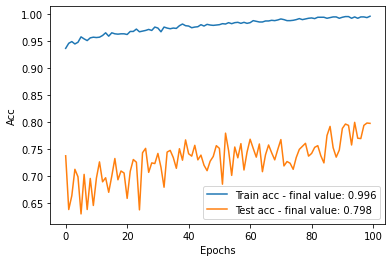

In [ ]:
acc = finetunig.history.history["acc"]; val_acc = finetunig.history.history["val_acc"]
plt.plot(acc, label="Train acc - final value: %.3f"%acc[-1])
plt.plot(val_acc, label="Test acc - final value: %.3f"%val_acc[-1])
plt.legend(); plt.xlabel("Epochs"); plt.ylabel("Acc"); plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


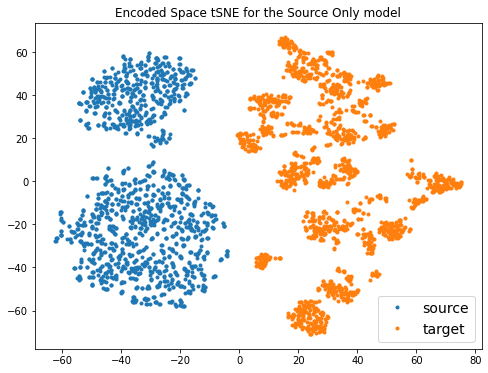

In [ ]:
LC25000_train_data_enc = finetunig.transform(LC25000_train_data_ex)
TCGA_cyclegan_train_data_enc = finetunig.transform(TCGA_cyclegan_train_data_ex)

np.random.seed(0)
X_ = np.concatenate((LC25000_train_data_enc, TCGA_cyclegan_train_data_enc))
X_tsne = TSNE(2).fit_transform(X_)
plt.figure(figsize=(8, 6))
plt.plot(X_tsne[:len(LC25000_train_data_ex), 0], X_tsne[:len(LC25000_train_data_ex), 1], '.', label="source")
plt.plot(X_tsne[len(LC25000_train_data_ex):, 0], X_tsne[len(LC25000_train_data_ex):, 1], '.', label="target")
plt.legend(fontsize=14)
plt.title("Encoded Space tSNE for the Source Only model")
plt.show()

In [ ]:
# convert the history.history dictionary to a pandas dataframe:     
hist_df = pd.DataFrame(finetunig.history.history) 

# or the describe() method:
hist_df.describe()

,loss,acc,val_loss,val_acc
count,100.000000,100.000000,100.000000,100.000000
mean,0.061603,0.978463,0.935832,0.732069
std,0.037491,0.014096,0.129076,0.036764
min,0.016669,0.936875,0.592600,0.630625
25%,0.031669,0.968594,0.841441,0.711563
50%,0.055272,0.981562,0.927585,0.736250
75%,0.084256,0.990000,1.041191,0.753906
max,0.196480,0.996250,1.219709,0.800000


In [ ]:
hist_df.to_csv("./Model/DANN_Model/MDD_512/MDD_source_Resnet_512_RMS_1e-6_cyclegan.csv")

# Fit with adaptation

### Run 1

In [ ]:
lr =1e-6
momentum = 0.9
alpha = 0.0002


encoder = load_resnet50()
task = get_task()

optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),  momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),  momentum=momentum)
optimizer_disc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),  momentum=momentum)

In [ ]:
mdd_1 = MDD(encoder, task,
            loss="categorical_crossentropy",
            metrics=["acc"],
            copy=False,
            lambda_=tf.Variable(0.),
            gamma=1,
            optimizer=optimizer_task,
            optimizer_enc=optimizer_enc,
            optimizer_disc=optimizer_disc,
            callbacks=[UpdateLambda(lambda_max=0.1)])

In [ ]:
mdd_1.fit(X=LC25000_train_data_ex[:-1], y=LC25000_train_lab[:-1], Xt=TCGA_cyclegan_train_data_ex, epochs=150, batch_size=8,  validation_data=(TCGA_cyclegan_train_data_ex, TCGA_cyclegan_train_lab))

Epoch 1/150
200/200 [==============================] - 14s 57ms/step - loss: 0.9355 - acc: 0.5975 - disc_loss: 1.5099 - val_loss: 0.8423 - val_acc: 0.9463
Epoch 2/150
200/200 [==============================] - 10s 48ms/step - loss: 0.5953 - acc: 0.8169 - disc_loss: 1.4406 - val_loss: 0.7666 - val_acc: 0.8131
Epoch 3/150
200/200 [==============================] - 9s 43ms/step - loss: 0.3601 - acc: 0.8706 - disc_loss: 1.3965 - val_loss: 0.5638 - val_acc: 0.8644
Epoch 4/150
200/200 [==============================] - 9s 43ms/step - loss: 0.2434 - acc: 0.9194 - disc_loss: 1.3442 - val_loss: 0.5680 - val_acc: 0.8019
Epoch 5/150
200/200 [==============================] - 9s 43ms/step - loss: 0.1827 - acc: 0.9344 - disc_loss: 1.2822 - val_loss: 0.5848 - val_acc: 0.7675
Epoch 6/150
200/200 [==============================] - 9s 43ms/step - loss: 0.1718 - acc: 0.9369 - disc_loss: 1.2333 - val_loss: 0.5361 - val_acc: 0.7875
Epoch 7/150
200/200 [==============================] - 9s 43ms/step - loss

### Run 2

In [ ]:
lr =1e-6
momentum = 0.9
alpha = 0.0002


encoder = load_resnet50()
task = get_task()

optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),  momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),  momentum=momentum)
optimizer_disc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),  momentum=momentum)

In [ ]:
mdd_1 = MDD(encoder, task,
            loss="categorical_crossentropy",
            metrics=["acc"],
            copy=False,
            lambda_=tf.Variable(0.),
            gamma=1,
            optimizer=optimizer_task,
            optimizer_enc=optimizer_enc,
            optimizer_disc=optimizer_disc,
            callbacks=[UpdateLambda(lambda_max=0.1)])

In [ ]:
mdd_1.fit(X=LC25000_train_data_ex[:-1], y=LC25000_train_lab[:-1], Xt=TCGA_cyclegan_train_data_ex, epochs=150, batch_size=8,  validation_data=(TCGA_cyclegan_train_data_ex, TCGA_cyclegan_train_lab))

Epoch 1/150
200/200 [==============================] - 15s 51ms/step - loss: 0.9333 - acc: 0.6438 - disc_loss: 1.5004 - val_loss: 0.8041 - val_acc: 0.9538
Epoch 2/150
200/200 [==============================] - 9s 44ms/step - loss: 0.5860 - acc: 0.8069 - disc_loss: 1.4036 - val_loss: 0.6931 - val_acc: 0.8737
Epoch 3/150
200/200 [==============================] - 9s 43ms/step - loss: 0.3449 - acc: 0.8888 - disc_loss: 1.3776 - val_loss: 0.5665 - val_acc: 0.8481
Epoch 4/150
200/200 [==============================] - 9s 43ms/step - loss: 0.2312 - acc: 0.9250 - disc_loss: 1.3122 - val_loss: 0.4729 - val_acc: 0.8394
Epoch 5/150
200/200 [==============================] - 9s 43ms/step - loss: 0.1800 - acc: 0.9356 - disc_loss: 1.2443 - val_loss: 0.4977 - val_acc: 0.8081
Epoch 6/150
200/200 [==============================] - 8s 42ms/step - loss: 0.1701 - acc: 0.9369 - disc_loss: 1.1873 - val_loss: 0.4412 - val_acc: 0.8313
Epoch 7/150
200/200 [==============================] - 8s 42ms/step - loss:

### Run 3

In [ ]:
lr =1e-6
momentum = 0.9
alpha = 0.0002


encoder = load_resnet50()
task = get_task()

optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),  momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),  momentum=momentum)
optimizer_disc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),  momentum=momentum)

In [ ]:
mdd_1 = MDD(encoder, task,
            loss="categorical_crossentropy",
            metrics=["acc"],
            copy=False,
            lambda_=tf.Variable(0.),
            gamma=1,
            optimizer=optimizer_task,
            optimizer_enc=optimizer_enc,
            optimizer_disc=optimizer_disc,
            callbacks=[UpdateLambda(lambda_max=0.1)])

In [ ]:
mdd_1.fit(X=LC25000_train_data_ex[:-1], y=LC25000_train_lab[:-1], Xt=TCGA_cyclegan_train_data_ex, epochs=150, batch_size=8,  validation_data=(TCGA_cyclegan_train_data_ex, TCGA_cyclegan_train_lab))

Epoch 1/150
200/200 [==============================] - 15s 52ms/step - loss: 0.9342 - acc: 0.6288 - disc_loss: 1.5193 - val_loss: 0.7805 - val_acc: 0.9769
Epoch 2/150
200/200 [==============================] - 9s 47ms/step - loss: 0.5902 - acc: 0.8131 - disc_loss: 1.4216 - val_loss: 0.7129 - val_acc: 0.8600
Epoch 3/150
200/200 [==============================] - 9s 43ms/step - loss: 0.3657 - acc: 0.8644 - disc_loss: 1.3510 - val_loss: 0.5830 - val_acc: 0.8469
Epoch 4/150
200/200 [==============================] - 8s 42ms/step - loss: 0.2490 - acc: 0.9162 - disc_loss: 1.3104 - val_loss: 0.4473 - val_acc: 0.8587
Epoch 5/150
200/200 [==============================] - 8s 42ms/step - loss: 0.1981 - acc: 0.9287 - disc_loss: 1.2387 - val_loss: 0.5093 - val_acc: 0.8081
Epoch 6/150
200/200 [==============================] - 8s 42ms/step - loss: 0.1734 - acc: 0.9312 - disc_loss: 1.1726 - val_loss: 0.4239 - val_acc: 0.8475
Epoch 7/150
200/200 [==============================] - 8s 42ms/step - loss:

### Run 4

In [ ]:
lr =1e-6
momentum = 0.9
alpha = 0.0002


encoder = load_resnet50()
task = get_task()

optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),  momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),  momentum=momentum)
optimizer_disc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),  momentum=momentum)

In [ ]:
mdd_1 = MDD(encoder, task,
            loss="categorical_crossentropy",
            metrics=["acc"],
            copy=False,
            lambda_=tf.Variable(0.),
            gamma=1,
            optimizer=optimizer_task,
            optimizer_enc=optimizer_enc,
            optimizer_disc=optimizer_disc,
            callbacks=[UpdateLambda(lambda_max=0.1)])

In [ ]:
mdd_1.fit(X=LC25000_train_data_ex[:-1], y=LC25000_train_lab[:-1], Xt=TCGA_cyclegan_train_data_ex, epochs=150, batch_size=8,  validation_data=(TCGA_cyclegan_train_data_ex, TCGA_cyclegan_train_lab))

Epoch 1/150
200/200 [==============================] - 14s 54ms/step - loss: 0.9309 - acc: 0.6438 - disc_loss: 1.4690 - val_loss: 0.8008 - val_acc: 0.9681
Epoch 2/150
200/200 [==============================] - 9s 47ms/step - loss: 0.5697 - acc: 0.8138 - disc_loss: 1.3943 - val_loss: 0.6951 - val_acc: 0.8781
Epoch 3/150
200/200 [==============================] - 9s 43ms/step - loss: 0.3358 - acc: 0.8888 - disc_loss: 1.3703 - val_loss: 0.4906 - val_acc: 0.8931
Epoch 4/150
200/200 [==============================] - 8s 42ms/step - loss: 0.2486 - acc: 0.9206 - disc_loss: 1.3182 - val_loss: 0.4955 - val_acc: 0.8288
Epoch 5/150
200/200 [==============================] - 8s 42ms/step - loss: 0.1828 - acc: 0.9362 - disc_loss: 1.2524 - val_loss: 0.4276 - val_acc: 0.8519
Epoch 6/150
200/200 [==============================] - 8s 42ms/step - loss: 0.1693 - acc: 0.9344 - disc_loss: 1.1789 - val_loss: 0.4292 - val_acc: 0.8425
Epoch 7/150
200/200 [==============================] - 8s 42ms/step - loss:

### Run 5

In [ ]:
lr =1e-6
momentum = 0.9
alpha = 0.0002


encoder = load_resnet50()
task = get_task()

optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),  momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),  momentum=momentum)
optimizer_disc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),  momentum=momentum)

In [ ]:
mdd_1 = MDD(encoder, task,
            loss="categorical_crossentropy",
            metrics=["acc"],
            copy=False,
            lambda_=tf.Variable(0.),
            gamma=1,
            optimizer=optimizer_task,
            optimizer_enc=optimizer_enc,
            optimizer_disc=optimizer_disc,
            callbacks=[UpdateLambda(lambda_max=0.1)])

In [ ]:
mdd_1.fit(X=LC25000_train_data_ex[:-1], y=LC25000_train_lab[:-1], Xt=TCGA_cyclegan_train_data_ex, epochs=150, batch_size=8,  validation_data=(TCGA_cyclegan_train_data_ex, TCGA_cyclegan_train_lab))

Epoch 1/150
200/200 [==============================] - 14s 53ms/step - loss: 0.9297 - acc: 0.6438 - disc_loss: 1.4971 - val_loss: 0.7382 - val_acc: 0.9787
Epoch 2/150
200/200 [==============================] - 9s 44ms/step - loss: 0.5567 - acc: 0.8281 - disc_loss: 1.4397 - val_loss: 0.6435 - val_acc: 0.8950
Epoch 3/150
200/200 [==============================] - 9s 43ms/step - loss: 0.3312 - acc: 0.8963 - disc_loss: 1.3957 - val_loss: 0.5755 - val_acc: 0.8213
Epoch 4/150
200/200 [==============================] - 9s 44ms/step - loss: 0.2332 - acc: 0.9237 - disc_loss: 1.3302 - val_loss: 0.4624 - val_acc: 0.8375
Epoch 5/150
200/200 [==============================] - 9s 44ms/step - loss: 0.1904 - acc: 0.9331 - disc_loss: 1.2803 - val_loss: 0.4630 - val_acc: 0.8300
Epoch 6/150
200/200 [==============================] - 9s 43ms/step - loss: 0.1716 - acc: 0.9337 - disc_loss: 1.2129 - val_loss: 0.4121 - val_acc: 0.8413
Epoch 7/150
200/200 [==============================] - 9s 43ms/step - loss:

### Result

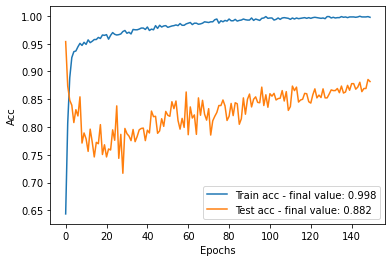

In [ ]:
acc = mdd_1.history.history["acc"]; val_acc = mdd_1.history.history["val_acc"]
plt.plot(acc, label="Train acc - final value: %.3f"%acc[-1])
plt.plot(val_acc, label="Test acc - final value: %.3f"%val_acc[-1])
plt.legend(); plt.xlabel("Epochs"); plt.ylabel("Acc"); plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


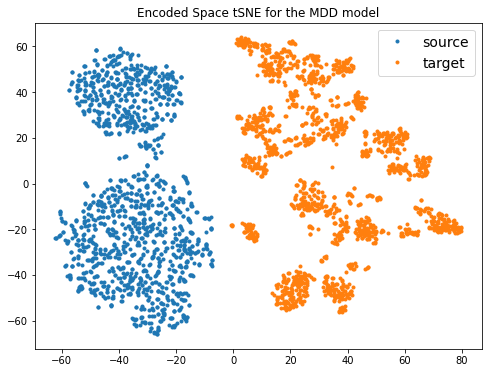

In [ ]:
LC25000_train_data_enc = mdd_1.transform(LC25000_train_data_ex)
TCGA_train_data_enc = mdd_1.transform(TCGA_cyclegan_train_data_ex)

np.random.seed(0)
X_ = np.concatenate((LC25000_train_data_enc, TCGA_train_data_enc))
X_tsne = TSNE(2).fit_transform(X_)
plt.figure(figsize=(8, 6))
plt.plot(X_tsne[:len(LC25000_train_data_ex), 0], X_tsne[:len(LC25000_train_data_ex), 1], '.', label="source")
plt.plot(X_tsne[len(LC25000_train_data_ex):, 0], X_tsne[len(LC25000_train_data_ex):, 1], '.', label="target")
plt.legend(fontsize=14)
plt.title("Encoded Space tSNE for the MDD model")
plt.show()

In [ ]:
# convert the history.history dictionary to a pandas dataframe:     
hist_df = pd.DataFrame(mdd_1.history.history) 

# or the describe() method:
hist_df.describe()

,loss,acc,disc_loss,val_loss,val_acc
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,0.058613,0.980137,0.335818,0.614842,0.829058
std,0.096501,0.035645,0.301598,0.065699,0.037455
min,0.005363,0.643750,0.007108,0.400062,0.716875
25%,0.016046,0.975625,0.135423,0.577996,0.798438
50%,0.032681,0.990000,0.241806,0.618577,0.838125
75%,0.073219,0.996250,0.425200,0.654763,0.858125
max,0.933333,0.999375,1.407357,0.804094,0.953750


In [ ]:
hist_df.to_csv("./Model/DANN_Model/MDD_512/MDD_Resnet_512_RMS_1e-6_g1_cyclegan.csv")

In [ ]:
import gc
gc.collect()

6787